<a href="https://colab.research.google.com/github/peeyushsinghal/EVA/blob/main/S10-Assignment/EVA_S10_TinyImageNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**cloning the models git hub **

In [1]:
!pip install -U albumentations

     |████████████████████████████████| 102 kB 13.1 MB/s 
     |████████████████████████████████| 47.6 MB 59.7 MB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [2]:
!git clone https://github.com/peeyushsinghal/common-pytorch-models.git

Cloning into 'common-pytorch-models'...
remote: Enumerating objects: 146, done.
remote: Counting objects: 100% (146/146), done.
remote: Compressing objects: 100% (140/140), done.
remote: Total 146 (delta 70), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (146/146), 44.11 KiB | 8.82 MiB/s, done.
Resolving deltas: 100% (70/70), done.


In [3]:
import os
os.getcwd() 
os.chdir('common-pytorch-models')

#### Setting Device and Seed

In [4]:
# loading helper functions
from utils.helper import seed_all, get_device, get_mean_std_dev

In [5]:
# check for default device

device = get_device()
print (f' device Status : {device}')
device

 device Status : cuda


device(type='cuda')

In [6]:
## setting seed for reproducibility
SEED = 42 # arbit seed, why 42 - because in hitch hikers guide to galaxy it is answer to everything
seed_all(SEED)

### Loading data

In [7]:
# Getting Mean and Standard Deviation of tinyimagenet dataset
mean, std_dev = get_mean_std_dev("TINYIMAGENET")
print(f"Mean : {mean}   STD: {std_dev}") 

Mean : (0.4802, 0.4481, 0.3975)   STD: (0.2302, 0.2265, 0.2262)


### Applying Transformations

In [8]:
from utils.transforms import apply_transforms_tiny_imagenet # custom transformations for custom resnet

train_transforms, test_transforms = apply_transforms_tiny_imagenet(mean,std_dev)

### Train and Test data

In [9]:
from utils.tinyimagenetdataset import TinyImageNet

trainset = TinyImageNet(root='./data', train=True,
                                        download=True, transform=train_transforms)

testset = TinyImageNet(root='./data', train=False,
                                       download=True, transform=test_transforms)

  0%|          | 0/120609 [00:00<?, ?it/s]

Files already downloaded and verified


 **Labels**

In [10]:
labels = trainset.classes
labels[:20]

['Egyptian cat',
 'reel',
 'volleyball',
 'rocking chair',
 'lemon',
 'bullfrog',
 'basketball',
 'cliff',
 'espresso',
 'plunger',
 'parking meter',
 'German shepherd',
 'dining table',
 'monarch',
 'brown bear',
 'school bus',
 'pizza',
 'guinea pig',
 'umbrella',
 'organ']

 **Train and Test set Dataloader**

In [11]:
import torch
batch_size = 512 # as required 

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)


testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

#### Visualizing Images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

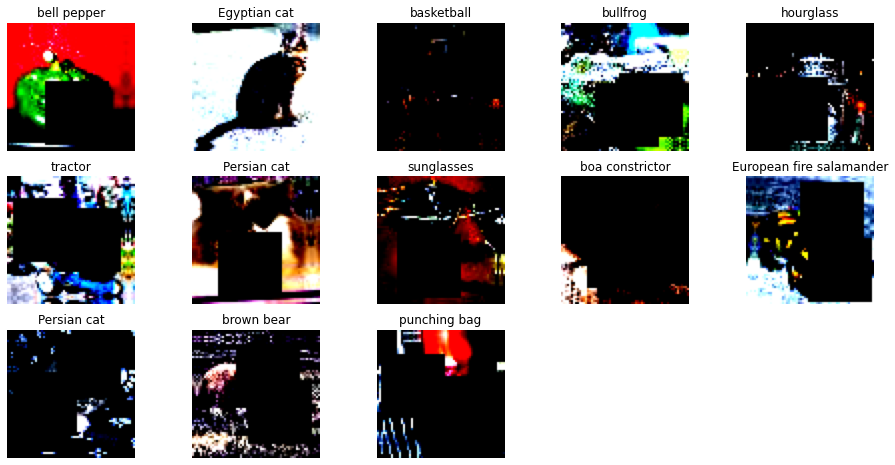

In [12]:
from utils.plot_utils import show_batch
show_batch(trainloader,labels,num_images=13) # for visualizing images

### 2. Network
Loading Model, understanding model params by checking summary

In [13]:
from models.resnet18 import resnet18
from utils.helper import model_summary # shows summary 

model = resnet18("BN").to(device) # creating model
model_summary(model, (3, 64, 64)) # shows model summary

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
        BasicBlock-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
       BasicBlock-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 32, 32]          73,728
      BatchNorm2d-14          [-1, 128,

### 3. Training and Testing

*   includes test and train functions
*   includes loop function, where test can happen after each epoch is trained

In [14]:
import torch.optim as optim # for optimizer
import torch.nn as nn # for network, criterion
import torch.nn.functional as F 


criterion = nn.CrossEntropyLoss()

# epochs = 24
epochs = 50
# lr = 0.01


optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay = 0.005)
# optimizer = optim.Adam(model.parameters(), lr=lr)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',\
                                                 factor=0.1, patience=10, threshold=0.001, threshold_mode='abs')

### 3.1 One Cycle Rate Finder

In [15]:
# from utils.lrfinder import LRFinder
# lr_finder = LRFinder(model,optimizer,criterion,device=device)
# lr_finder.range_test(trainloader, testloader, start_lr=1e-5, end_lr=2, num_iter=len(trainloader), step_mode="exp")
# lr_finder.plot()
# lr_finder.reset()

In [16]:
# best_loss = lr_finder.best_loss
# LRMAX  = lr_finder.history["lr"][lr_finder.history["loss"].index(best_loss)]
# LRMIN = LRMAX / 10
# print("Best Loss: %s\n Max Learning Rate: %s \n Min Learning Rate: %s" % (best_loss,LRMAX,LRMIN))

In [17]:
epochs=50

In [18]:
# scheduler = optim.lr_scheduler.OneCycleLR(optimizer, LRMAX,  epochs=epochs, steps_per_epoch=len(trainloader), pct_start=20/50, div_factor=10.0, final_div_factor=10.0, three_phase=False, last_epoch=- 1, verbose=False)

In [ ]:
from main import trainer, train, test # including wrapper function of train and test
# train_accuracy, train_losses, test_accuracy, test_losses = trainer(model,device, trainloader, testloader, optimizer,epochs,criterion,scheduler)
train_accuracy, train_losses, test_accuracy, test_losses = trainer(model,device, trainloader, testloader, optimizer,epochs,criterion,scheduler = None)
# train_accuracy, train_losses, test_accuracy, test_losses = trainer(model,device, trainloader, testloader, optimizer,epochs,criterion)

EPOCH: 1


Loss=4.274374961853027 Batch_id=150 Accuracy=4.36: 100%|██████████| 151/151 [19:29<00:00,  7.74s/it]



Test set: Average loss: 0.0001, Accuracy: 2073/33000 (6.28%)

EPOCH: 2


Loss=4.027602195739746 Batch_id=150 Accuracy=10.07: 100%|██████████| 151/151 [19:28<00:00,  7.74s/it]



Test set: Average loss: 0.0001, Accuracy: 3643/33000 (11.04%)

EPOCH: 3


Loss=3.822450876235962 Batch_id=150 Accuracy=14.08: 100%|██████████| 151/151 [19:28<00:00,  7.74s/it]



Test set: Average loss: 0.0001, Accuracy: 4026/33000 (12.20%)

EPOCH: 4


Loss=3.6432547569274902 Batch_id=150 Accuracy=17.32: 100%|██████████| 151/151 [19:29<00:00,  7.74s/it]



Test set: Average loss: 0.0001, Accuracy: 5438/33000 (16.48%)

EPOCH: 5


Loss=3.60723876953125 Batch_id=150 Accuracy=19.86: 100%|██████████| 151/151 [19:30<00:00,  7.75s/it]



Test set: Average loss: 0.0001, Accuracy: 5218/33000 (15.81%)

EPOCH: 6


Loss=3.4971320629119873 Batch_id=150 Accuracy=21.71: 100%|██████████| 151/151 [19:29<00:00,  7.75s/it]



Test set: Average loss: 0.0001, Accuracy: 5261/33000 (15.94%)

EPOCH: 7


Loss=3.3571345806121826 Batch_id=124 Accuracy=23.42:  83%|████████▎ | 125/151 [16:12<03:21,  7.75s/it]

### 4. Checking results
visualizing train_accuracy, train_losses, test_accuracy, test_losses

In [ ]:
from utils.plot_utils import plot_metrics

plot_metrics(train_accuracy, train_losses, test_accuracy, test_losses)

In [ ]:
from utils.plot_utils import show_predicted_actual

show_predicted_actual(model, device, testloader, labels,num_images=20)

### Misclassified images

In [ ]:
from utils.plot_utils import misclassified_images

images_misclassified = misclassified_images(model, testloader, device, mean, std_dev)

*Class Level Accuarcy*

In [ ]:
## Checking class level accuracy
from utils.helper import evaluate_classwise_accuracy
evaluate_classwise_accuracy(model, device, labels, testloader)


### Grad Cam output for 20 misclassified images

first top 10 images are shown
then next 10 images are shown

In [ ]:
from utils.grad_cam import generate_gradcam, plot_gradcam

target_layers = ["layer1", "layer2", "layer3", "layer4"]
gradcam_output, probs, predicted_classes = generate_gradcam(images_misclassified[:10], model, target_layers, device)
plot_gradcam(gradcam_output, target_layers, labels, (3, 64, 64), predicted_classes, images_misclassified[:10])

In [ ]:
from utils.grad_cam import generate_gradcam, plot_gradcam

target_layers = ["layer1", "layer2", "layer3", "layer4"]
gradcam_output, probs, predicted_classes = generate_gradcam(images_misclassified[10:20], model, target_layers, device)
plot_gradcam(gradcam_output, target_layers, labels, (3, 64, 64), predicted_classes, images_misclassified[10:20])